In [108]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [109]:
# загрузка и предобработка
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import string
!pip install -qq transformers
!pip install -qq datasets

from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AdamW, get_scheduler
# обучение
import torch
from torch.utils.data import DataLoader
# предобработка и финальный отчет по метрикам
from sklearn import preprocessing
from sklearn.metrics import classification_report
# прогресс бар
from tqdm import tqdm
# очистка кешей
import gc
# размер шрифта в графиках
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [110]:
df = pd.read_csv('/home/konstantin/my_project_dir/NLP_project/NLP/music_album_reviews.csv')

In [111]:
df.head()

,Review,Rating
0,i think i actually under-rate ok computer if a...,5.0
1,i get why radiohead rub a lot of people the wr...,5.0
2,i would like to think i am good about not lett...,4.5
3,there are radiohead devotees like there were o...,4.0
4,i wrote a shining excellent review for this al...,5.0


In [112]:
df['Rating'].value_counts()

Rating
5.0    29534
4.5    17793
4.0    14213
3.5     7048
3.0     4430
2.5     2210
2.0     1396
1.5      640
1.0      525
0.5      398
Name: count, dtype: int64

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80271 entries, 0 to 80270
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  80245 non-null  object 
 1   Rating  78187 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [114]:
df.isnull().sum()

Review      26
Rating    2084
dtype: int64

In [115]:
df[df['Rating'] <= 2.0].isnull().sum()

Review    1
Rating    0
dtype: int64

In [116]:
df.isnull().value_counts()

Review  Rating
False   False     78162
        True       2083
True    False        25
        True          1
Name: count, dtype: int64

In [117]:
df1 = df.fillna(method='ffill')

/tmp/ipykernel_143916/3232044947.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df1 = df.fillna(method='ffill')


In [118]:
df1.isnull().value_counts()

Review  Rating
False   False     80271
Name: count, dtype: int64

In [119]:
import re
def clean(inp: str) -> str:

    inp = inp.translate(str.maketrans(string.punctuation, " "*len(string.punctuation)))

    inp = re.sub(r'\s+', ' ', inp.lower())

    return inp

In [120]:
for text in df1['Review']:
    clean(text)


In [121]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80271 entries, 0 to 80270
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  80271 non-null  object 
 1   Rating  80271 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [122]:
df1.isnull().sum()

Review    0
Rating    0
dtype: int64

In [123]:
!pip install augmentex

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [124]:
from augmentex import WordAug

word_aug = WordAug(
    unit_prob=0.4, # Percentage of the phrase to which augmentations will be applied
    min_aug=1, # Minimum number of augmentations
    max_aug=4, # Maximum number of augmentations
    lang="eng", # supports: "rus", "eng"
    platform="pc", # supports: "pc", "mobile"
    random_seed=42,
    )

In [125]:
df_0_5 = df1[df1['Rating'] == 0.5].copy()

In [126]:
df_aug = pd.DataFrame(['Review'], ['Rating'])
df_aug

,0
Rating,Review


In [24]:
# df_0_5['Review'].str.replace(r'[^\w\s]+', '')

In [25]:
# word_aug.augment(text=text, action="replace")

In [127]:
df_0_5 = df_0_5.loc[df_0_5['Review'].str.len() > 3]

In [128]:
new_text_05 = []
for text in df_0_5['Review']:
    new_text_05.append(word_aug.augment(text=text, action="delete"))


In [129]:
df_aug_05 = pd.DataFrame(data=new_text_05, columns=['Review'])

In [130]:
df_aug_05['Rating'] = 0.5

In [131]:
len(df_aug_05['Rating']), len(df_aug_05['Review'])

(409, 409)

In [132]:
df_aug_05.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  409 non-null    object 
 1   Rating  409 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.5+ KB


In [32]:
#new_df_0_5 = pd.concat([df_0_5, df_aug])

In [33]:
#new_df_0_5.reset_index().drop(columns='index')

In [133]:
df1 = pd.concat([df1, df_aug_05]).reset_index().drop(columns='index')

In [134]:
df1.sample(frac=1).reset_index(drop=True)

,Review,Rating
0,this is like a 1960s cult-horror film put to m...,4.0
1,steely dans most jazzy work more jazz than roc...,5.0
2,blood on the tracks has been classified as dyl...,4.5
3,this album is not overrated. the reason you ke...,5.0
4,i like this album a lot. it goes from a blues ...,4.0
...,...,...
80675,no sei nem onde comear a falar deste cd. desde...,5.0
80676,despite all the sales records and histrionics ...,3.5
80677,a true masterpiece one of there best from ther...,5.0
80678,airbag - 4.5 paranoid android - 4.5 subterrane...,4.5


In [135]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80680 entries, 0 to 80679
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  80680 non-null  object 
 1   Rating  80680 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [37]:
######

In [136]:
df_1_0 = df1[df1['Rating'] == 1.0].copy()

In [137]:
df_aug_10 = pd.DataFrame(['Review'], ['Rating'])
df_aug_10

,0
Rating,Review


In [138]:
df_1_0['Review'].str.replace(r'[^\w\s]+', '')
new_text_10 = []
for text in df_1_0['Review']:
    new_text_10.append(word_aug.augment(text=text, action="reverse"))

df_aug_10 = pd.DataFrame(data=new_text_10, columns=['Review'])
df_aug_10['Rating'] = 1.0

In [139]:
len(df_aug_10['Rating']), len(df_aug_10['Review'])

(543, 543)

In [140]:
df_aug_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  543 non-null    object 
 1   Rating  543 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.6+ KB


In [141]:
df1 = pd.concat([df1, df_aug_10]).reset_index().drop(columns='index')

In [37]:
##############

In [142]:
df_1_5 = df1[df1['Rating'] == 1.5].copy()
df_aug_15 = pd.DataFrame(['Review'], ['Rating'])
df_1_5['Review'].str.replace(r'[^\w\s]+', '')
new_text_15 = []
for text in df_1_5['Review']:
    if len(text.split()) > 2:
        new_text_15.append(word_aug.augment(text=text, action="reverse"))

df_aug_15 = pd.DataFrame(data=new_text_15, columns=['Review'])
df_aug_15['Rating'] = 1.5
len(df_aug_15['Rating']), len(df_aug_15['Review'])


(649, 649)

In [143]:
df_aug_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  649 non-null    object 
 1   Rating  649 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.3+ KB


In [145]:
df1 = pd.concat([df1, df_aug_15]).reset_index().drop(columns='index')

In [146]:
df1.sample(frac=1).reset_index(drop=True)

,Review,Rating
0,un album trs bizarre. la premire partie est fa...,4.5
1,one of the best jazz albums i have heard both ...,5.0
2,my first exposure to funkadelic did not exactl...,4.0
3,vikernes strips the ever-evolving and complete...,4.0
4,just lay back and enjoy the man. that is coltr...,4.0
...,...,...
82516,my favorites children of the damned the prison...,4.5
82517,. 2 . . acdc dee...,4.5
82518,another fantastic punk album although the prod...,3.5
82519,to say that ok computer is the best album of t...,5.0


In [147]:
df1.dropna(axis=0, inplace=True)

In [148]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82521 entries, 0 to 82520
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  82521 non-null  object 
 1   Rating  82521 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.3+ MB


In [149]:
df1['Review'][0], df['Rating'][0]

('i think i actually under-rate ok computer if anything. that is bonkers right? it is been my favourite album for over two decades now - but that right there is exactly the problem. i heard it when i was 15 and it was maybe the fourth or fifth album of any kind i would ever truly paid attention to front-to-back and the first that was not essentially forced upon me by my parents or general peer pressure at school. it was the first time i would ever decided it might be worth actually trying out music for real and the very first album i ever landed on just so happened to be the best one? nah. it is far too convenient. i keep side-eyeing it uneasily when i see it sitting at the top of my favourite albums list. surely the rush of hearing it now cannot be the same as it was when i was hearing it as a teenager. surely at least one of the 3500 albums i have heard since has surpassed it. right?! and yet i have been having this thought repeatedly for well over a decade now and every time i come 

In [150]:
df1['Review'].str.strip().str.lower()

0        i think i actually under-rate ok computer if a...
1        i get why radiohead rub a lot of people the wr...
2        i would like to think i am good about not lett...
3        there are radiohead devotees like there were o...
4        i wrote a shining excellent review for this al...
                               ...                        
82516    this is a bleak and miserable album perhaps no...
82517    it is hard to go wrong with just straightforwa...
82518    i first checked this out in whole during my pi...
82519    when i first heard of this album i thought it ...
82520    this album just turns me off and i am complete...
Name: Review, Length: 82521, dtype: object

In [151]:
df1['Review'].info(), df1['Rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 82521 entries, 0 to 82520
Series name: Review
Non-Null Count  Dtype 
--------------  ----- 
82521 non-null  object
dtypes: object(1)
memory usage: 644.8+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 82521 entries, 0 to 82520
Series name: Rating
Non-Null Count  Dtype  
--------------  -----  
82521 non-null  float64
dtypes: float64(1)
memory usage: 644.8 KB


(None, None)

In [152]:
df1 = df1[['Review', 'Rating']]
df1.columns = ['text', 'labels']
df1.head()

,text,labels
0,i think i actually under-rate ok computer if a...,5.0
1,i get why radiohead rub a lot of people the wr...,5.0
2,i would like to think i am good about not lett...,4.5
3,there are radiohead devotees like there were o...,4.0
4,i wrote a shining excellent review for this al...,5.0


<Axes: >

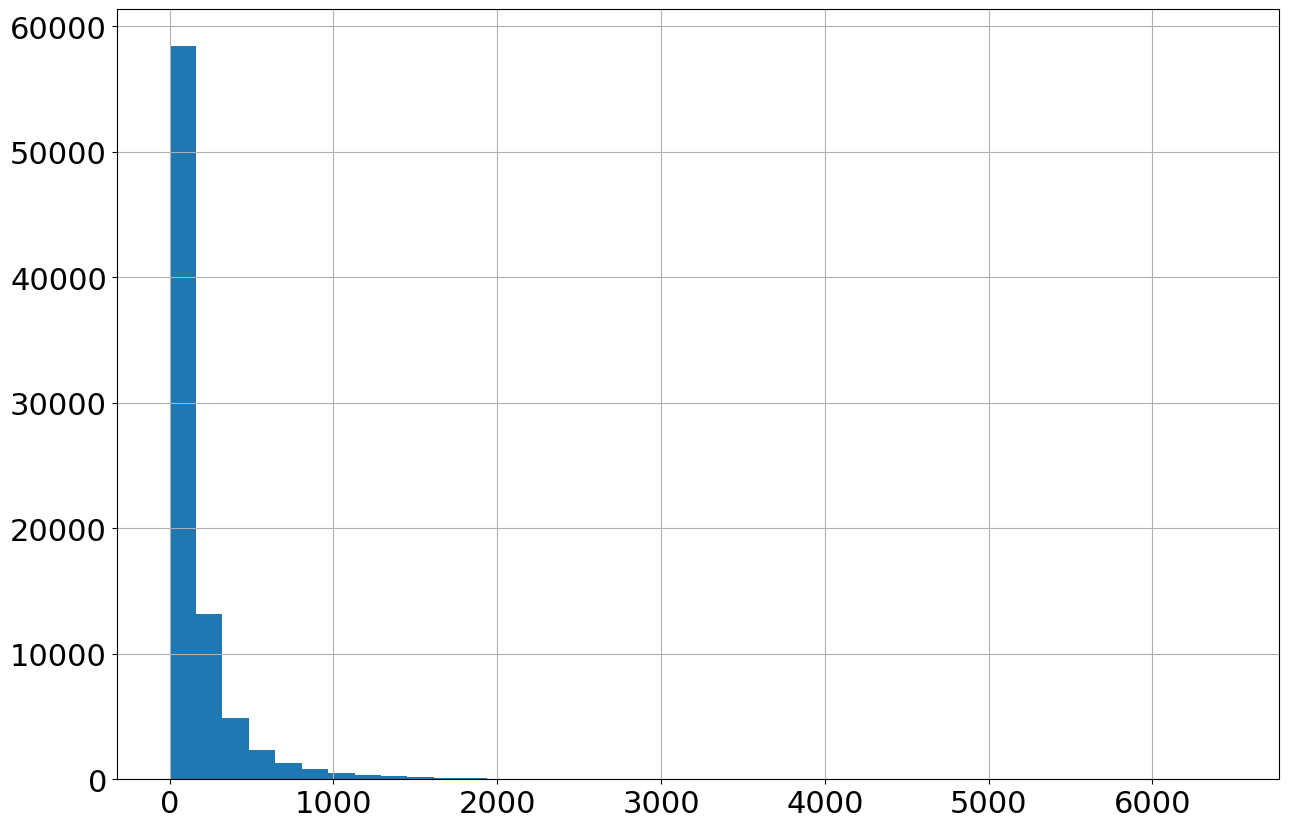

In [153]:
df1['text'].apply(lambda x: len(str(x).split())).hist(figsize=(15, 10), bins=40)

array([[<Axes: title={'center': 'labels'}>]], dtype=object)

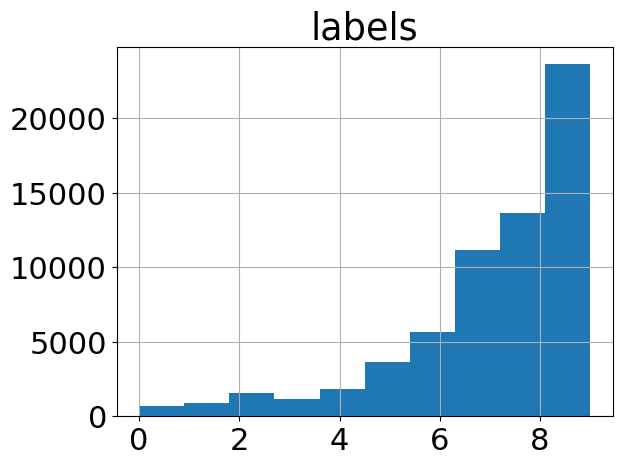

In [200]:
df1.hist('labels')

In [155]:
labels2num = {
    0.5: 0,
    1.0: 1,
    1.5: 2,
    2.0: 3,
    2.5: 4,
    3.0: 5,
    3.5: 6,
    4.0: 7,
    4.5: 8,
    5.0: 9,
}
labels2num = {k: int(v) for k, v in labels2num.items()}

num2labels = {
    0: 0.5,
    1: 1.0,
    2: 1.5,
    3: 2.0,
    4: 2.5,
    5: 3.0,
    6: 3.5,
    7: 4.0,
    8: 4.5,
    9: 5.0,
}
num2labels = {k: int(v) for k, v in num2labels.items()}

In [156]:
df1['labels'] = df1['labels'].map(labels2num)

In [157]:
df1.fillna(method='ffill')

/tmp/ipykernel_143916/598575452.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df1.fillna(method='ffill')


,text,labels
0,i think i actually under-rate ok computer if a...,9
1,i get why radiohead rub a lot of people the wr...,9
2,i would like to think i am good about not lett...,8
3,there are radiohead devotees like there were o...,7
4,i wrote a shining excellent review for this al...,9
...,...,...
82516,this is a bleak and Miserable album perhaps no...,2
82517,it is hard to go wrong with just straightforwa...,2
82518,i first checked this out in whole during my pi...,2
82519,when i first heard of this album i thought it ...,2


In [69]:
# df1.drop_duplicates()

In [158]:
print(df1['labels'])

0        9
1        9
2        8
3        7
4        9
        ..
82516    2
82517    2
82518    2
82519    2
82520    2
Name: labels, Length: 82521, dtype: int64


In [160]:
df1 = df1.loc[(df1['text'].str.len() > 3) & (df1['text'].str.len() < 1150)].copy()

In [161]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63898 entries, 5 to 82520
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    63898 non-null  object
 1   labels  63898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [162]:
print(df1['text'])

5        hurrah finally i had my first radiohead experi...
6        radiohead i nigel godrich wytworzyli prawdziwi...
7        so let me get this straight. a bunch of one-hi...
8        i can sort of understand the praise this album...
10       so yeah i decided highest rated on the site? g...
                               ...                        
82513    philip glass Just does not do it for me. Which...
82516    this is a bleak and Miserable album perhaps no...
82517    it is hard to go wrong with just straightforwa...
82518    i first checked this out in whole during my pi...
82520    this album just turns me off and I am complete...
Name: text, Length: 63898, dtype: object


In [163]:
df1 = df1.sample(frac=1).reset_index(drop=True)
train = df1[:int(len(df1)*0.85)]
test =  df1[int(len(df1)*0.85):]

In [164]:
len(train), len(test)

(54313, 9585)

In [165]:
print(len(train['labels'].value_counts()), len(test['labels'].value_counts()))
df1.info()

10 10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63898 entries, 0 to 63897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    63898 non-null  object
 1   labels  63898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 998.5+ KB


In [166]:
print(test['labels'].value_counts(), train['labels'].value_counts())
df1.info()

labels
9    3542
8    2046
7    1665
6     867
5     578
4     252
2     251
3     174
1     121
0      89
Name: count, dtype: int64 labels
9    20081
8    11593
7     9469
6     4793
5     3096
4     1593
2     1334
3      996
1      752
0      606
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63898 entries, 0 to 63897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    63898 non-null  object
 1   labels  63898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 998.5+ KB


In [167]:
print(train[train['labels'] == 2])

                                                    text  labels
27     kashmir is Basically The prototype of progress...       2
53     the swans keep making this horrible long doubl...       2
96     i am Obviously in the minority. remember never...       2
97     thirty years on from its release there is litt...       2
137    I could not Enjoy one second from this instrum...       2
...                                                  ...     ...
54176  I have tried listening to this forever And sti...       2
54189  some parts of elevation are a complete ripoff ...       2
54190  after hearing about what a great band joy divi...       2
54205  really enjoy this album for what it is. 90s ro...       2
54275  roger waters discovered that he could produce ...       2

[1334 rows x 2 columns]


In [168]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [169]:
df1.isnull().sum()

text      0
labels    0
dtype: int64

In [171]:
model_name = "cointegrated/LaBSE-en-ru"

tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=10)
model = AutoModelForSequenceClassification.from_pretrained("/home/konstantin/Рабочий стол/NLP_mfti/Dataset_/6/")

In [172]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(55083, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [173]:
tokenizer

BertTokenizerFast(name_or_path='cointegrated/LaBSE-en-ru', vocab_size=55083, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [174]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(55083, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [175]:
names = list(model.named_parameters())
names[:6]

[('bert.embeddings.word_embeddings.weight',
  Parameter containing:
  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.1458,  0.1406, -0.0617,  ..., -0.0131, -0.0651,  0.0827],
          [-0.0005,  0.0164, -0.0240,  ..., -0.0217, -0.0244, -0.0542],
          ...,
          [-0.0846, -0.1349,  0.2057,  ...,  0.0686, -0.2711, -0.1173],
          [-0.0959,  0.0968, -0.0111,  ..., -0.0082, -0.0471,  0.0292],
          [-0.1986,  0.1389,  0.0213,  ...,  0.0607, -0.1313, -0.0792]],
         requires_grad=True)),
 ('bert.embeddings.position_embeddings.weight',
  Parameter containing:
  tensor([[-0.0766, -0.0023, -0.0312,  ...,  0.0336, -0.0083, -0.0431],
          [-0.0243,  0.0238, -0.0153,  ...,  0.0132,  0.0123,  0.0078],
          [-0.0177,  0.0114, -0.0234,  ..., -0.0429,  0.0074,  0.0058],
          ...,
          [-0.0204, -0.0186,  0.0021,  ..., -0.0401,  0.0139,  0.0067],
          [-0.0416, -0.0363,  0.0166,  ...,  0.0573,  0.0190, -0.0176],
      

In [176]:
torch.cuda.empty_cache()
import gc
gc.collect()

564

In [177]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cpu')

In [178]:
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [179]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 54313
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 9585
    })
})

In [180]:
dataset = dataset.map(lambda e: tokenizer(e['text'], truncation = True, max_length=350, padding='max_length'), batched=True)

Map:   0%|          | 0/54313 [00:00<?, ? examples/s]

Map:   0%|          | 0/9585 [00:00<?, ? examples/s]

In [181]:
pytorch_style_columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']
dataset = dataset.remove_columns(list(set(list(dataset['train'].features.keys())) - set(pytorch_style_columns)))

In [182]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 54313
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9585
    })
})

In [183]:

dataset.set_format(type='torch', columns=pytorch_style_columns) # , device='cuda')
#dataset.set_format(type='torch', columns="input_ids", device='cuda')

In [184]:
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=3)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=1)

In [185]:
len(train_dataloader)

18105

In [186]:
optimizer = AdamW(model.parameters(), lr=2e-6)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps
)

/home/konstantin/my_project_dir/my_project_env/lib/python3.11/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [187]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [188]:
next(iter(train_dataloader))

{'labels': tensor([9, 9, 8]),
 'input_ids': tensor([[    2,   600,   991,  ...,     0,     0,     0],
         [    2,    77,  6403,  ...,     0,     0,     0],
         [    2,  1738, 46806,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

In [189]:
from tqdm.auto import tqdm
from collections import deque

best_f1 = 0.
avg_loss = deque([], maxlen=30)

for epoch in range(num_epochs):    
    print(40*'-', '\nepoch', epoch+1)    
    model.train()
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch in tepoch:            
            model.train()            
            batch = {k: v.to(device) for k, v in batch.items()}            
            outputs = model(**batch)
            # print(outputs)            
            loss = outputs.loss            
            loss.backward()            
            optimizer.step()            
            lr_scheduler.step()            
            optimizer.zero_grad()            
            avg_loss.append(loss.item())            
            tepoch.set_postfix(loss=np.array(list(avg_loss)).mean())

    losses = []    
    print('\nvalidating')    
    f1 = load_metric('f1')
    acc = load_metric('accuracy')
    precision = load_metric('precision')
    recall = load_metric('recall')
    
    with torch.no_grad():        
        model.eval()        
        for batch in tqdm(test_dataloader):            
            batch = {k: v.to(device) for k, v in batch.items()}            
            with torch.no_grad():
                outputs = model(**batch)            
            logits = outputs.logits            
            predictions = torch.argmax(logits, dim=-1)            
            f1.add_batch(predictions=predictions, references=batch["labels"])
            acc.add_batch(predictions=predictions, references=batch["labels"])
            precision.add_batch(predictions=predictions, references=batch["labels"])
            recall.add_batch(predictions=predictions, references=batch["labels"])
        
        print('weighted summary:')
        print('Test acc:', acc.compute()['accuracy'])
        print('Test precision:', precision.compute(average = 'macro')['precision'])
        print('Test recall:', recall.compute(average = 'macro')['recall'])
        f1_weighted = f1.compute(average = 'macro')['f1']
        print('Test f1:', f1_weighted, '\n')
        
        if f1_weighted > best_f1:            
            best_f1 = f1_weighted            
            model.save_pretrained(f"best_model_f1_max={best_f1}_len=511")
    
    model.train()

---------------------------------------- 
epoch 1


  0%|          | 0/18105 [00:00<?, ?batch/s]


validating


/tmp/ipykernel_143916/1618502672.py:50: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  f1 = load_metric('f1')
/home/konstantin/my_project_dir/my_project_env/lib/python3.11/site-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


ConnectionError: Couldn't reach https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/f1/f1.py (ConnectionError(MaxRetryError('HTTPSConnectionPool(host=\'raw.githubusercontent.com\', port=443): Max retries exceeded with url: /huggingface/datasets/2.19.0/metrics/f1/f1.py (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x792ad60bc4d0>: Failed to resolve \'raw.githubusercontent.com\' ([Errno -3] Temporary failure in name resolution)"))')))

In [190]:
true = []
preds = []

model.eval()
for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}    
    with torch.no_grad():
        outputs = model(**batch)    
    logits = outputs.logits    
    predictions = torch.argmax(logits, dim=-1)    
    true += batch["labels"].detach().cpu().numpy().tolist()
    preds += predictions.detach().cpu().numpy().tolist()

  0%|          | 0/9585 [00:00<?, ?it/s]

In [ ]:
#true
#preds

In [192]:
labels2num = {
    0.5: 0,
    1.0: 1,
    1.5: 2,
    2.0: 3,
    2.5: 4,
    3.0: 5,
    3.5: 6,
    4.0: 7,
    4.5: 8,
    5.0: 9,
}
labels2num = {k: v for k, v in labels2num.items()}

num2labels = {
    0: 0.5,
    1: 1.0,
    2: 1.5,
    3: 2.0,
    4: 2.5,
    5: 3.0,
    6: 3.5,
    7: 4.0,
    8: 4.5,
    9: 5.0,
}
num2labels = {k: v for k, v in num2labels.items()}
num2labels

{0: 0.5,
 1: 1.0,
 2: 1.5,
 3: 2.0,
 4: 2.5,
 5: 3.0,
 6: 3.5,
 7: 4.0,
 8: 4.5,
 9: 5.0}

In [194]:
len(preds)

9585

In [198]:
from sklearn import preprocessing
from sklearn.metrics import classification_report

In [199]:
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.41      0.51      0.45        89
           1       0.14      0.01      0.02       121
           2       0.70      0.74      0.72       251
           3       0.29      0.10      0.15       174
           4       0.32      0.27      0.29       252
           5       0.43      0.28      0.34       578
           6       0.42      0.33      0.37       867
           7       0.40      0.42      0.41      1665
           8       0.43      0.34      0.38      2046
           9       0.65      0.83      0.73      3542

    accuracy                           0.53      9585
   macro avg       0.42      0.38      0.39      9585
weighted avg       0.50      0.53      0.51      9585

